# 从0开始的DCNN-NiN(网络中的网络)
## 简要回顾
1. 神经网络发展伊始的LeNet, 结构为2*[卷积(通道数为6, 16)-sigmoid激活-平均池化]+Flatten()+Linear(400, 120, 84, 10)的全连接.  
2. 随着IamgeNet2012数据集的公布+GPU的开发, 更深层次的神经网络AlexNet出现。变化是卷积层更多(1[11]+1[5]+3[3], 其中第一个卷积操作大幅减小图像宽高, 后续卷积则通过填充保持了宽高, 每一个加号代表ReLU激活和最大池化, 最大池化将图像宽高减半), 激活函数变为ReLU, 通道数大幅增加(1, 96, 256, 384, 384, 256)，最后仍然采用Flatten()+全连接层得到多分类的输出.  
3. 接着出现了块设计的思想, 代表VGG. 这一思想提供了一种DCNN设计的一种范式. VGG网络包含多个VGG块。每一个VGG块由多个卷积层链接最后加上池化层，值得注意的是，卷积层数量由超参数确定，卷积操作不改变图像宽高，卷积核较小，均为3x3, 其他参数包含输入通道数和输出通道数(准确说是这个块的第一个卷积层，后续的卷积层输入输出通道数目一致，均为第一个卷积层的输出通道数)。原始的VGG网络包含5个块(`conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))`)。最后采用全连接的方式得到输出。
> LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。 AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。 或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。 

## NiN
NiN块仅包含卷积操作，第一个卷积层是可指定的，后面两个均为1x1卷积层，它们相当于在每个像素位置（针对每个高度和宽度）应用一个全连接层。  
NiN块间使用折半最大汇聚层链接  
NiN使用四个NiN块，其输出通道数等于标签类别的数量。最后放一个全局平均汇聚层（global average pooling layer），生成一个对数几率 （logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量  
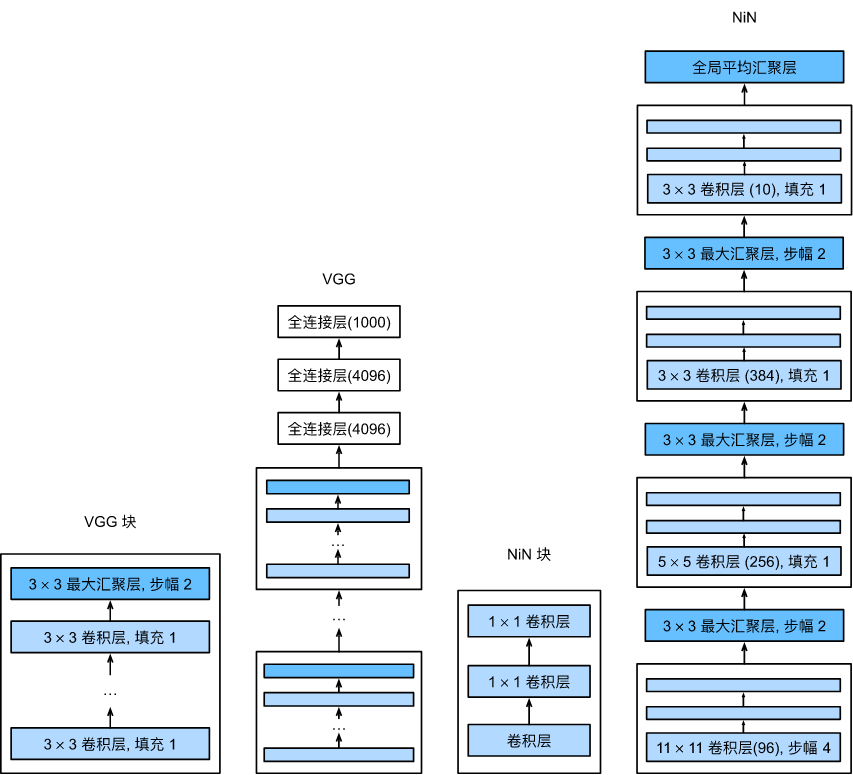

In [2]:
import torch
from torch import nn
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

In [6]:
def nin_blk(kernel_size, in_, out_, st, pd):
    # kernel_size, input_channel, output_channel, stride, padding
    return nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, st, pd), nn.ReLU(), # HW-, C+
        nn.Conv2d(out_, out_, 1), nn.ReLU(), # 不改变NCWH的任何一个
        nn.Conv2d(out_, out_, 1), nn.ReLU()  # 但实现的是不同通道像素的全连接
    )

nin_net = nn.Sequential(
    # 1x224x224
    nin_blk(11, 1, 24, 4, 0), nn.MaxPool2d(2, 2), # 96x54x54, 96x27x27
    nin_blk(3, 24, 64, 1, 1), nn.MaxPool2d(2, 2), # 256x26x26, 256x12x12
    nin_blk(3, 64, 98, 1, 1), nn.MaxPool2d(2, 2), # 384x12x12, 384x5x5
    nn.Dropout(0.2),
    nin_blk(3, 98, 10, 1, 1), # 10x5x5
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten() # 10x1x1 (1, 10)
)
X = torch.randn(1, 1, 224, 224)
for layer in nin_net:
    X = layer(X)
    print(f"{layer.__class__.__name__} outshape={X.shape}")

Sequential outshape=torch.Size([1, 24, 54, 54])
MaxPool2d outshape=torch.Size([1, 24, 27, 27])
Sequential outshape=torch.Size([1, 64, 27, 27])
MaxPool2d outshape=torch.Size([1, 64, 13, 13])
Sequential outshape=torch.Size([1, 98, 13, 13])
MaxPool2d outshape=torch.Size([1, 98, 6, 6])
Dropout outshape=torch.Size([1, 98, 6, 6])
Sequential outshape=torch.Size([1, 10, 6, 6])
AdaptiveAvgPool2d outshape=torch.Size([1, 10, 1, 1])
Flatten outshape=torch.Size([1, 10])


NiN包含4个NiN-Block, 每一个NiN-Block包含一个手动设置的卷积层和2个1x1的卷积层。前3个卷积核由大变小11-5-3, 其中第一个块的卷积将宽高折为四分之一, 后面两个块的卷积不对图像宽高作出改变. 随后是一个权重衰退层，接上一个3x3的NiN-Block将通道数量降到10.最后是一个全局平均池化, 也即对于每一个通道, 整体求平均值. 最后Flatten进行展平

在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。 换言之，每个中间活性值$h$以暂退概率$p$由随机变量$h'$替换:
$$\begin{split}\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}\end{split}$$


loss 2.300, train acc 0.127, test acc 0.187
loss 2.249, train acc 0.222, test acc 0.294
loss 2.115, train acc 0.287, test acc 0.298
loss 1.953, train acc 0.296, test acc 0.319
loss 1.820, train acc 0.317, test acc 0.312
loss 1.780, train acc 0.327, test acc 0.337
loss 1.758, train acc 0.333, test acc 0.339
loss 1.686, train acc 0.371, test acc 0.461
loss 1.346, train acc 0.492, test acc 0.508
loss 1.241, train acc 0.522, test acc 0.513

4687.3 examples/sec on cuda:0


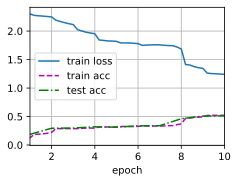

In [8]:
lr, epoch_num, gpu, batch_size = 0.03, 10, torch.device("cuda:0"), 128
train_iter, test_iter = d2l.loadFashionMnist(batch_size, 224)
d2l.train_ch6(nin_net, train_iter, test_iter, epoch_num, lr, gpu)

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())